**주제 : ML/DL 방법론을 통한 시간대 별 자전거 수요 예측**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

df = pd.read_csv('london_merged.csv',parse_dates = ['timestamp'])
df.head(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


### A. 기본 탐색 과정

1. 데이터 불러오기 및 기본 구조 파악하기

In [8]:
print('데이터의 구조는', df.shape)
print()
print('데이터의 타입은', df.dtypes) # dtypes 를 통해 각 피처에 대한 데이터 타입을 파악할 수 있음
print()
print('데이터 칼럼은', df.columns)

데이터의 구조는 (17414, 10)

데이터의 타입은 timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

데이터 칼럼은 Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')


2. 데이터 결측치 확인

In [9]:
df.isnull().sum() ## 결측치 없음 

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

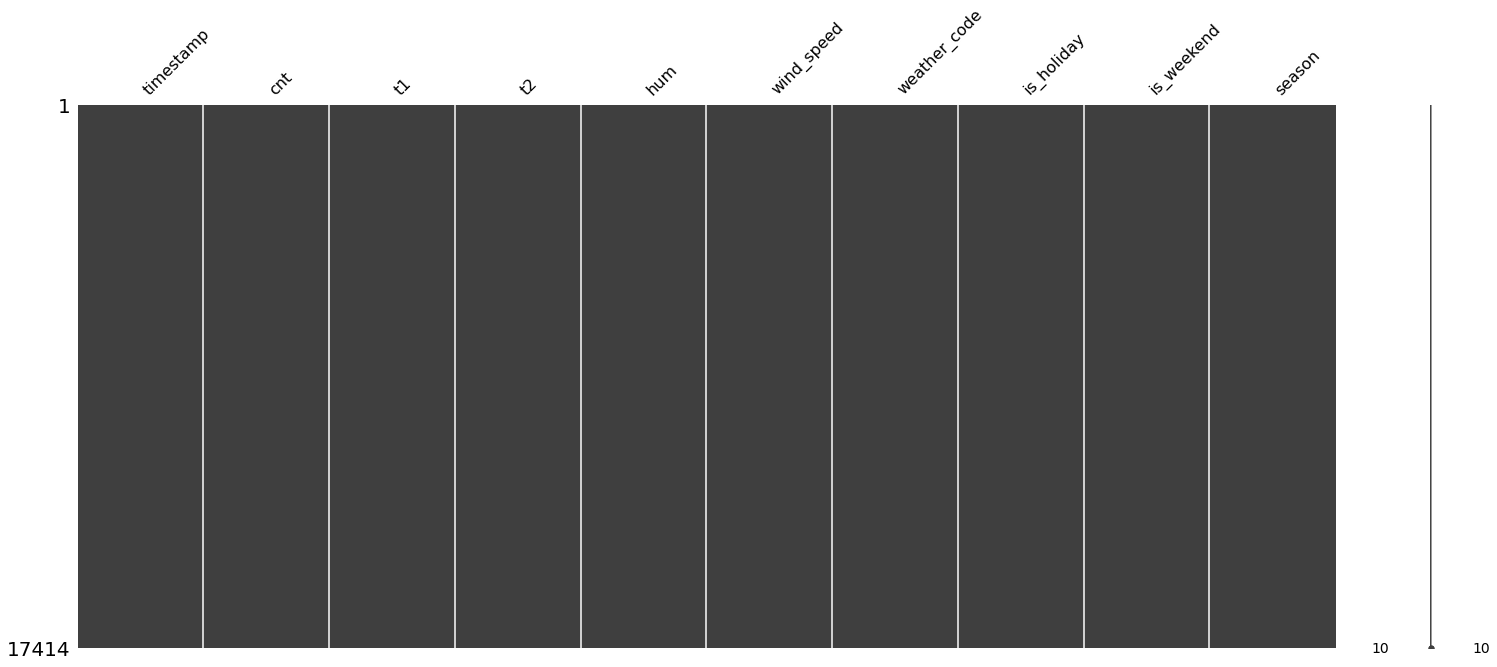

In [10]:
msno.matrix(df)
plt.show()

3. 피처 생성 (피처 엔지니어링) 

* timestamp 에서 개별적인 날짜를 뽑아내 새로운 열 생성하기

In [11]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,dayofweek,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,6,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,6,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,6,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,6,4


### B. 탐색적 데이터 분석 EDA

1. ``value_counts()`` 를 통해 범주형 변수 분포 간단하게 확인

In [12]:
df.year.value_counts()

2016    8699
2015    8643
2017      72
Name: year, dtype: int64

In [13]:
df.dayofweek.value_counts()

0    2508
6    2505
1    2505
3    2492
2    2489
5    2465
4    2450
Name: dayofweek, dtype: int64

In [14]:
df.weather_code.value_counts()

1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
26.0      60
10.0      14
Name: weather_code, dtype: int64

2. 그래프를 통한 EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


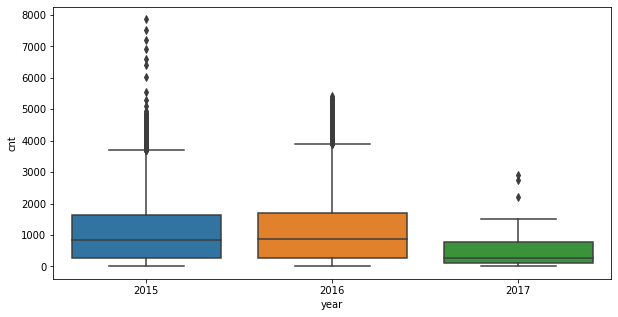

In [15]:
# 연도별 자전거 대여량 박스플롯 시각화 
a, b = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(df.year , df.cnt)

## 17년도에 들어서 이용객들이 많이 감소함 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


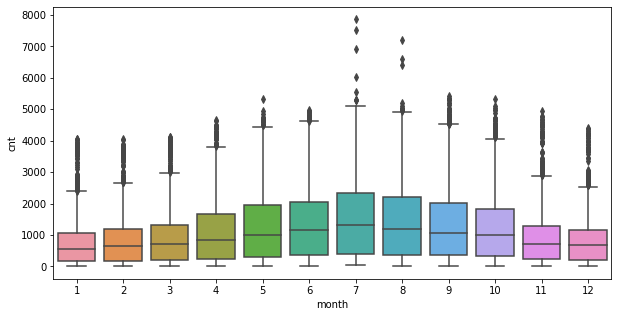

In [16]:
a, b = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(df.month , df.cnt) ## 여름기간에 대여량이 높음 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


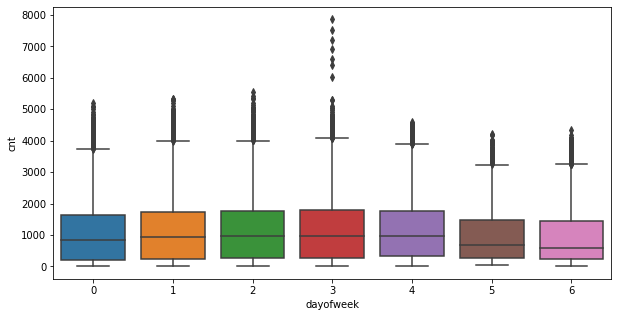

In [17]:
a, b = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(df.dayofweek , df.cnt) ## 토, 일요일에 오히려 이용량 감소 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


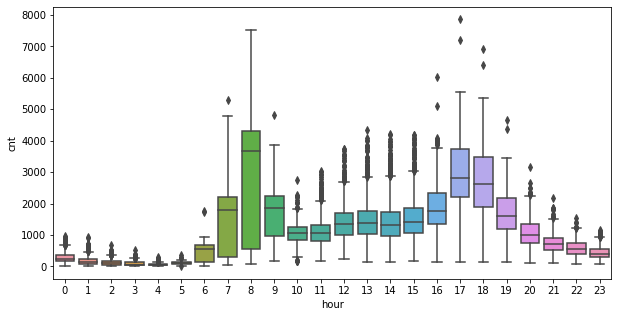

In [18]:
a, b = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(df.hour , df.cnt) ## 출퇴근 시간에 주로 이용 

In [23]:
# 막대 그래프 그리는 함수 만들기 
## 변수만 넣으면 자동으로 나오게끔 하기 (여러개 작업하기 편하도록)
def plot_bar(data, feature) : 
  fig = plt.figure(figsize=(12,3))
  sns.barplot(x=feature, y = 'cnt', data = data, palette = 'Set3', orient = 'v')

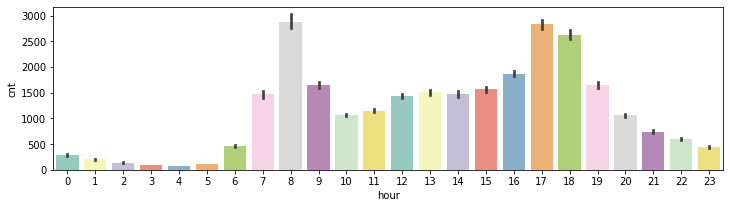

In [24]:
plot_bar(df, 'hour')

### C. 데이터 전처리

1. 이상치 제거

* 가장 손쉬운 방법 : 시그마 방법, IQR 방법
* 이외의, k-means 나 DBSCAN 방법이 있음

In [32]:
def is_outliers(s) : 
  lower_limit = s.mean() - (s.std()*3)
  upper_limit = s.mean() + (s.std()*3)
  return ~ s.between(lower_limit, upper_limit) # 양 극간에 있는 값을 이상치로 간주 

In [33]:
df_out = df[~df.groupby('hour')['cnt'].apply(is_outliers)]

print('이상치 제거 전 : ', df.shape)
print('이상치 제거 후 : ', df_out.shape) # 150개 정도가 제거됨 

이상치 제거 전 :  (17414, 14)
이상치 제거 후 :  (17265, 14)


In [34]:
df_out.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
year                     int64
month                    int64
dayofweek                int64
hour                     int64
dtype: object

2. 범주형 데이터 처리 
* cateogry 형변환
* 더미변수 변환 (0과 1의 숫자로만 구성되도록) 

ML/DL 이 학습할 수 있는 형태로 변환하기 


In [ ]:
df_out['weather_code'] = df_out['weather_code'].astype('category')
df_out['season'] = df_out['season'].astype('category')
df_out['year'] = df_out['year'].astype('category')
df_out['month'] = df_out['month'].astype('category')
df_out['hour'] = df_out['hour'].astype('category')

In [45]:
df_out.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code          category
is_holiday             float64
is_weekend             float64
season                category
year                  category
month                 category
dayofweek                int64
hour                  category
dtype: object

In [46]:
df_out.season

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
17409    3.0
17410    3.0
17411    3.0
17412    3.0
17413    3.0
Name: season, Length: 17265, dtype: category
Categories (4, float64): [0.0, 1.0, 2.0, 3.0]

In [47]:
df_out = pd.get_dummies(df_out, columns = ['weather_code','season','year','month','hour' ])
df_out.head(2) ## 범주형 변수들이 모두 이진의 수로 변경됨을 확인할 수 있음 

,timestamp,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,dayofweek,weather_code_1.0,weather_code_2.0,weather_code_3.0,weather_code_4.0,weather_code_7.0,weather_code_10.0,weather_code_26.0,season_0.0,season_1.0,season_2.0,season_3.0,year_2015,year_2016,year_2017,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,0.0,1.0,6,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,0.0,1.0,6,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
df_out.shape
# cnt : 종속변수 
# 그외 : 독립변수 

(17265, 59)

3. 훈련셋, 테스트셋으로 나누기 

In [49]:
# X 와 Y set 으로 나누기 
df_y = df_out['cnt']
df_x = df_out.drop(['timestamp','cnt'], axis=1)
df_x.head(2)

,t1,t2,hum,wind_speed,is_holiday,is_weekend,dayofweek,weather_code_1.0,weather_code_2.0,weather_code_3.0,weather_code_4.0,weather_code_7.0,weather_code_10.0,weather_code_26.0,season_0.0,season_1.0,season_2.0,season_3.0,year_2015,year_2016,year_2017,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,3.0,2.0,93.0,6.0,0.0,1.0,6,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.0,2.5,93.0,5.0,0.0,1.0,6,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
df_y.head()

0    182
1    138
2    134
3     72
4     47
Name: cnt, dtype: int64

In [52]:
# 훈련용, 테스트용 데이터 분리 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, random_state=66, test_size = 0.3, shuffle = False) 

## 시계열 데이터는 섞으면 절대 안되므로, suffle = False 옵션을 설정한다. 

In [53]:
print('x_train 구조 : ', x_train.shape)
print('y_train 구조 : ', y_train.shape)
print('x_test 구조 : ', x_test.shape)
print('y_test 구조 : ', y_test.shape)

x_train 구조 :  (12085, 57)
y_train 구조 :  (12085,)
x_test 구조 :  (5180, 57)
y_test 구조 :  (5180,)


### D. 머신러닝 딥러닝 분석 모델 적용하기

1. 딥러닝

* 머신러닝의 세부 : 인공신경망 기반의 머신러닝

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import EarlyStopping

In [55]:
model = Sequential()
model.add(Dense(units = 160, activation = 'relu', input_dim = 57))
model.add(Dense(units = 60, activation = 'relu'))
model.add(Dense(units = 20, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear')) 

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               9280      
                                                                 
 dense_1 (Dense)             (None, 60)                9660      
                                                                 
 dense_2 (Dense)             (None, 20)                1220      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 20,181
Trainable params: 20,181
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(loss = 'mae', optimizer= 'adam', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'loss', patience = 5, mode='min' ) # 과적합이 되지 않도록 loss 가 5번정도 올라가면 멈춰 달라는 뜻 
history = model.fit(x_train, y_train, epochs = 50, batch_size = 1, validation_split = 0.1, callbacks = [early_stopping]) # 전체 데이터의 50번 반복, 데이터 넣을땐 하나씩 넣기 
## validation_split : 매 epoch 마다 훈련이 잘 되고 있는지 검증하기 위한 데이터 분리 비율 (과적합 방지) : val_loss 잘 살펴보기 

Epoch 1/50
10876/10876 [==============================] - 22s 2ms/step - loss: 493.7468 - mae: 493.7468 - val_loss: 411.4292 - val_mae: 411.4292
Epoch 2/50
10876/10876 [==============================] - 21s 2ms/step - loss: 299.5708 - mae: 299.5708 - val_loss: 314.3728 - val_mae: 314.3728
Epoch 3/50
10876/10876 [==============================] - 25s 2ms/step - loss: 236.5385 - mae: 236.5385 - val_loss: 272.1313 - val_mae: 272.1313
Epoch 4/50
10876/10876 [==============================] - 23s 2ms/step - loss: 208.1227 - mae: 208.1227 - val_loss: 203.2022 - val_mae: 203.2022
Epoch 5/50
10876/10876 [==============================] - 20s 2ms/step - loss: 185.8916 - mae: 185.8916 - val_loss: 179.5493 - val_mae: 179.5493
Epoch 6/50
10876/10876 [==============================] - 21s 2ms/step - loss: 168.7934 - mae: 168.7934 - val_loss: 160.9055 - val_mae: 160.9055
Epoch 7/50
10876/10876 [==============================] - 24s 2ms/step - loss: 161.3708 - mae: 161.3708 - val_loss: 194.7072 - val

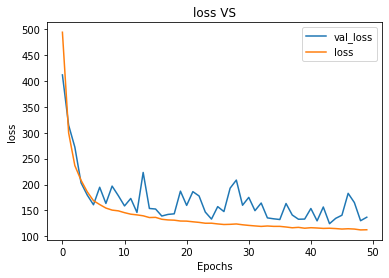

In [59]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('loss VS')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])
plt.show()

# 학습 회수에 따라 loss가 점차 감소함을 알 수 있음 ; 15번 정도 넘어가면 거의 차이가 없음 
# val_loss 도 전반적으로 낮은 수준으로 유지됨 

In [60]:
y_predict = model.predict(x_test)

In [61]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict) : 
  return np.sqrt(mean_squared_error(y_test, y_predict))

print('딥러닝 RMSE : ', RMSE(y_test, y_predict))

딥러닝 RMSE :  262.45294058537024


2. 머신러닝

* 회귀트리 기반 모델 : 랜덤 포레스트, xgboost, lightGBM 
* 앙상블 모형 : 배깅 , 부스팅
* 모형 평가 : RMSE
* 머신러닝에선 최적의 파라미터를 잘 찾는 것이 중요 

In [63]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 16 ) # 100개의 트리 모형
rf.fit(x_train, y_train)
rf_result = rf.predict(x_test)

print('랜덤포레스트 RMSE : ', RMSE(y_test, rf_result))

랜덤포레스트 RMSE :  303.6417775662534


In [66]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators = 100, random_state = 16)
xgb.fit(x_train, y_train)
xgb_result = xgb.predict(x_test)
print('부스팅 RMSE : ', RMSE(y_test, xgb_result))

[04:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
부스팅 RMSE :  485.08509052866196


In [65]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimator = 100, random_state=16)
lgb.fit(x_train, y_train)
lgb_result = lgb.predict(x_test)
print('lightgbm RMSE : ', RMSE(y_test, lgb_result))

lightgbm RMSE :  323.2746495922864


3. 모형별로 비교해보기 

* 4개 모형을 돌린 결과를 하나의 데이터 프레임으로 만들기
* 분포 시각화 

In [70]:
xgb = pd.DataFrame(xgb_result)
rf = pd.DataFrame(rf_result)
dnn = pd.DataFrame(y_predict)
lgbm = pd.DataFrame(lgb_result)
compare = pd.DataFrame(y_test).reset_index(drop=True)

In [71]:
compare['xgb'] = xgb
compare['rf'] = rf
compare['dnn'] = dnn
compare['lgbm'] = lgbm
compare.head()
# 실제값, 모형으로 예측한 값

,cnt,xgb,rf,dnn,lgbm
0,1885,1049.221069,1700.24,2312.665283,1830.345197
1,2175,1302.989868,1803.82,2582.592773,2133.296789
2,2485,1797.603760,2191.37,2894.098633,2590.899050
3,2882,1998.709351,2206.67,2748.401367,2613.783086
4,2965,2026.297852,2276.35,2646.722412,2306.341169


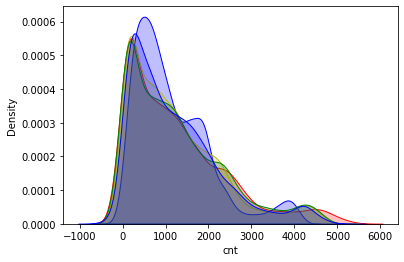

In [74]:
sns.kdeplot(compare['cnt'], shade = True, color = 'r')
sns.kdeplot(compare['xgb'], shade = True, color = 'b')
sns.kdeplot(compare['rf'], shade = True, color = 'y')
sns.kdeplot(compare['dnn'], shade = True, color = 'g')
sns.kdeplot(compare['lgbm'], shade = True, color = 'b')

### E. 시계열 딥러닝 분석 

* cnt(자전거 대여량) 변수만을 활용하여 패턴을 기반으로 예측해보기
* 시계열 데이터는 자기상관성이 존재 : 차수 추정 
* rnn
* lstm 
* gru 

In [75]:
df = pd.read_csv('london_merged.csv',parse_dates = ['timestamp'])
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [77]:
train = df.iloc[:17000, 1:2] 
test = df.iloc[17000 : ,1:2]
print(train.shape , test.shape)

(17000, 1) (414, 1)


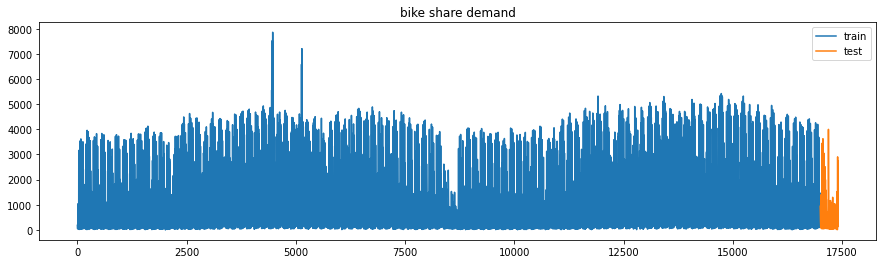

In [78]:
df.cnt[:17000].plot(figsize=(15,4), legend=True)
df.cnt[17000:].plot(figsize=(15,4), legend=True)
plt.legend(['train','test'])
plt.title('bike share demand')
plt.show()

1. 차수 추정

In [79]:
# 시계열 차수 추정 라이브러리
from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags = 20, method = 'ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713]


<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

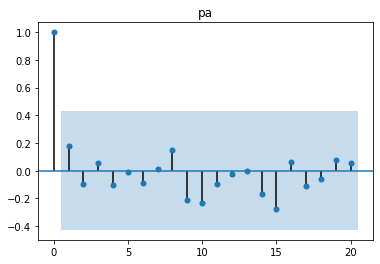

In [81]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=20, method = 'ols', title='pa').show

2. 스케일링
* 단위 차이 보정
* 정규분포를 따르지 않는 경우 예측의 정확성이 떨어지는 경우가 있음 
* 본 강의에서는 ``minmaxscaler()`` 를 사용

In [82]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)

In [83]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

3. train 데이터를 한시간 단위로 시프트 시키기


In [84]:
X_train = []
y_train = [] 
for i in range(1,17000) : 
  X_train.append(train_scaled[i-1:i,0]) # 한시간 전 시프트 된 것을 X에 넣기
  y_train.append(train_scaled[i,0]) # 일반 시간을 y에 넣기 

X_train, y_train = np.array(X_train), np.array(y_train)

In [85]:
X_train.shape

(16999, 1)

4. 시계열은 3차원 array로 학습시켜야 함

In [86]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(16999, 1, 1)

#### **시계열 딥러닝 : RNN** 

* 연속적인 데이터 분석, 시계열 분석에 활용되고 있다. 
* 과거의 입력값을 네트워크에 잔존 시켜서, 출력에 영향을 미치는, 즉 과거의 정보를 보관한다는 점에서 일반적인 딥러닝과 차이가 있다. 

In [87]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN

In [88]:
rnn = Sequential()
rnn.add(SimpleRNN(activation = 'relu', units = 6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1)) # 회귀분석이니까 linear 로 

In [89]:
print(rnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6)                 48        
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
rnn.compile(loss='mse', optimizer = 'adam', metrics=['mse'])

In [93]:
rnn.fit(X_train, y_train, batch_size = 1,  epochs=2)
# X_train : 1시간 전으로 shift 된 데이터
# y_train ; 원래 데이터

Epoch 1/2
16999/16999 [==============================] - 61s 3ms/step - loss: 0.0080 - mse: 0.0080
Epoch 2/2
16999/16999 [==============================] - 36s 2ms/step - loss: 0.0077 - mse: 0.0077


In [94]:
inputs = sc.transform(test)
inputs.shape

(414, 1)

In [96]:
X_test = []
for i in range(1,415) : 
  X_test.append(inputs[i-1:i , 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(414, 1, 1)

In [97]:
rnn = rnn.predict(X_test) # 예측
rnn = sc.inverse_transform(rnn) # 스케일 작업 한 것을 원래 값 범위로 되돌리기

In [98]:
test1 = pd.DataFrame(test)
rnn1 = pd.DataFrame(rnn)

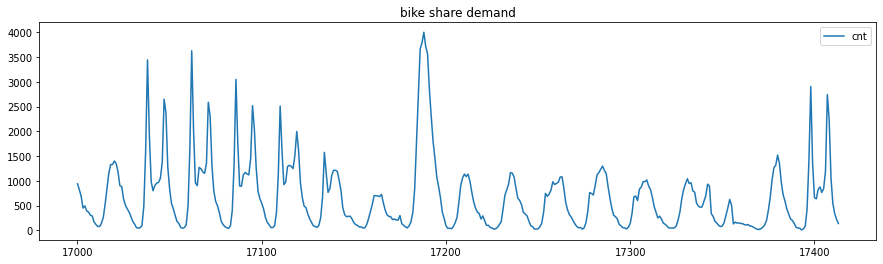

In [99]:
test1.plot(figsize=(15,4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

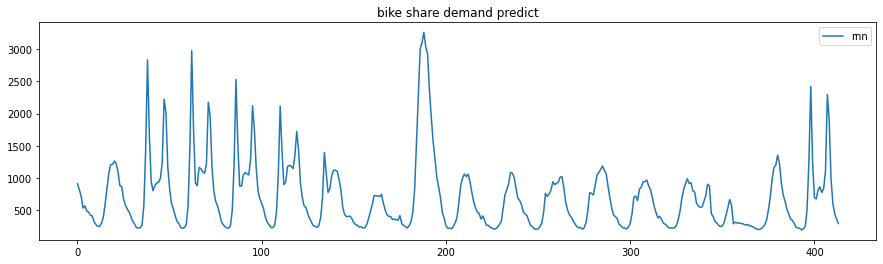

In [104]:
rnn1.plot(figsize=(15,4), legend=True)
plt.legend(['rnn'])
plt.title('bike share demand predict')
plt.show()

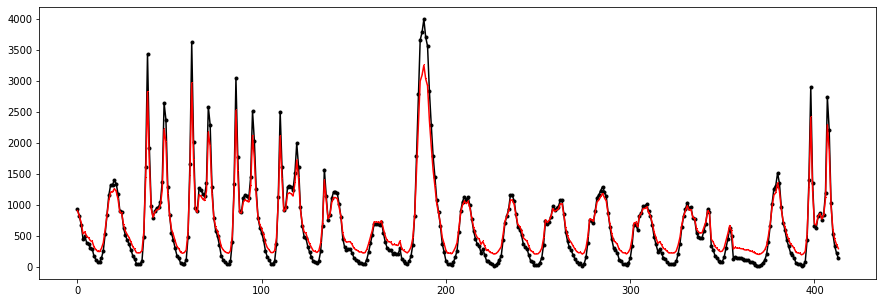

In [103]:
# 위의 두 그래프를 겹쳐 그리기
test = np.array(test)
plt.figure(figsize=(15,5))
plt.plot(test, marker = '.', label='cnt', color = 'black')
plt.plot(rnn, marker=',', label='RNN', color = 'red') # peak 타임에서는 rnn 모형이 과소예측하는 것을 살펴볼 수 있다. 

#### **시계열 딥러닝 : LSTM** 

* RNN 모형으로 구축하면 시간의 흐름에 따라 입력된 정보의 값이 소멸되는 경사하강 문제를 가지게 된다. 이러한 문제를 해결하기 위해 기억을 장기적으로 할 수 있도록 메모리 블록을 도입한 것이 LSTM (기존 RNN 의 단점을 극복) 
* 통상적으로 성능이 놓음 
* 그러나 과적합 주의하기 

In [126]:
from keras.layers.recurrent import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation ='relu', input_shape = (1,1)))
lstm.add(Dense(units=1, activation = 'linear' ))

In [127]:
print(lstm.summary()) # 파라미터의 개수가 rnn 보다 훨씬 많음 
# 그만큼 좀 더 정교하게 학습을 하게 된다는 의미 & 과적합 문제가 발생할 수 있는 문제 (단점)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6)                 192       
                                                                 
 dense_8 (Dense)             (None, 1)                 7         
                                                                 
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
None


In [128]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(X_train, y_train, batch_size=2, epochs=2)

Epoch 1/2
8500/8500 [==============================] - 32s 3ms/step - loss: 0.0085 - mse: 0.0085
Epoch 2/2
8500/8500 [==============================] - 29s 3ms/step - loss: 0.0068 - mse: 0.0068


In [129]:
lstm = lstm.predict(X_test)
lstm = sc.inverse_transform(lstm)

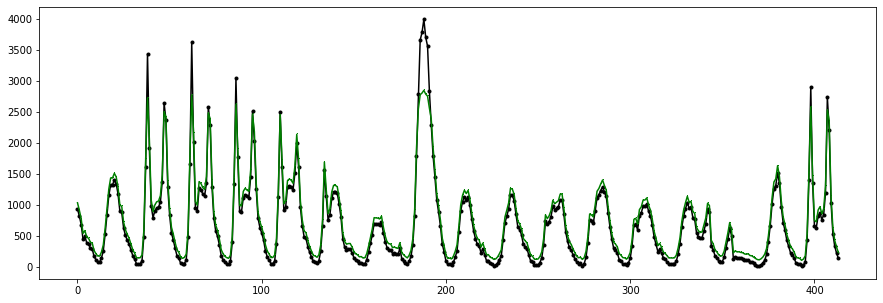

In [130]:
plt.figure(figsize=(15,5))
plt.plot(test, marker = '.', label='cnt', color = 'black')
plt.plot(lstm, marker=',', label='lstm', color = 'green') 

#### **시계열 딥러닝 : GRU**

* LSTM 의 과적합 문제를 보완한 모형 
* unit 의 개수는 줄여주는 반면 성능은 동일한 수준으로 유지

In [120]:
from keras.layers.recurrent import GRU

gru = Sequential()
gru.add(GRU(units=6, activation = 'relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation = 'linear'))

In [121]:
gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6)                 144       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [122]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 77s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 2/2
16999/16999 [==============================] - 43s 3ms/step - loss: 0.0074 - mse: 0.0074


In [123]:
gru = gru.predict(X_test)
gru = sc.inverse_transform(gru)

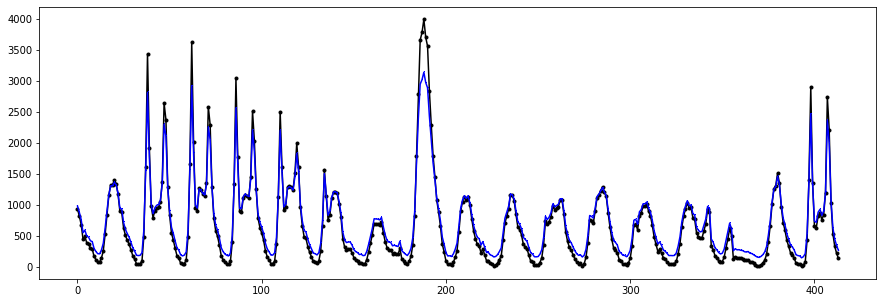

In [124]:
plt.figure(figsize=(15,5))
plt.plot(test, marker = '.', label='cnt', color = 'black')
plt.plot(gru, marker=',', label='gru', color = 'blue') 

#### 모형 비교

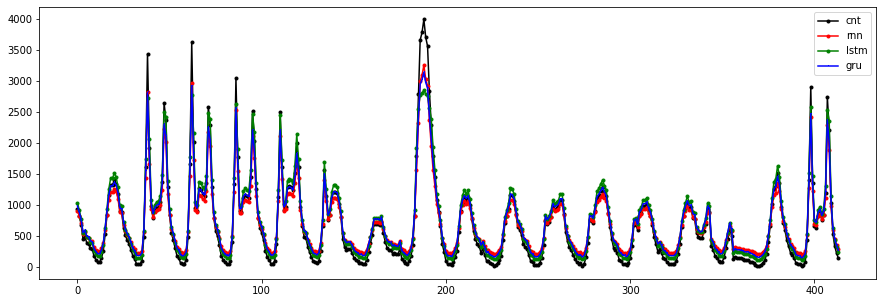

In [133]:
plt.figure(figsize=(15,5))
plt.plot(test, marker = '.', label='cnt', color = 'black')
plt.plot(rnn, marker = '.', label='rnn', color = 'red')
plt.plot(lstm, marker = '.', label='lstm', color = 'green')
plt.plot(gru, marker=',', label='gru', color = 'blue') 
plt.legend()

In [135]:
print('RNN RMSE : ', RMSE(test, rnn))
print('LSTM RMSE : ', RMSE(test, lstm))
print('GRU RMSE : ', RMSE(test, gru))

RNN RMSE :  166.29210191193005
LSTM RMSE :  156.44114195790047
GRU RMSE :  150.09280983395726
